<a href="https://colab.research.google.com/github/tigju/DS-Unit-1-Sprint-2-Statistics/blob/master/module3/LS_DS_123_Introduction_to_Bayesian_Inference_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lambda School Data Science Module 123

## Introduction to Bayesian Inference




## Assignment - Code it up!

We used pure math to apply Bayes Theorem to drug tests. Now write Python code to reproduce the results! This is purposefully open ended - you'll have to think about how you should represent probabilities and events. You can and should look things up.

Specific goals/targets:

### 1) Write a function 

`def prob_drunk_given_positive(prob_drunk_prior, false_positive_rate, true_positive_rate):` 

In this example, imagine that individuals are taking a breathalyzer test with an 8% false positive rate, a 100% true positive rate, and that our prior belief about drunk driving in the population is 1/1000. 
 - What is the probability that a person is drunk after one positive breathalyzer test?
 - What is the probability that a person is drunk after two positive breathalyzer tests?
 - How many positive breathalyzer tests are needed in order to have a probability that's greater than 95% that a person is drunk beyond the legal limit?

### 2) Explore `scipy.stats.bayes_mvs`  
Read its documentation, and experiment with it on data you've tested in other ways earlier this week.
 - Create a visualization comparing the results of a Bayesian approach to a traditional/frequentist approach. (with a large sample size they should look close to identical, however, take this opportunity to practice visualizing condfidence intervals in general. The following are some potential ways that you could visualize confidence intervals on your graph:
  - [Matplotlib Error Bars](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.errorbar.html)
  - [Seaborn barplot with error bars](https://seaborn.pydata.org/generated/seaborn.barplot.html)
  - [Vertical ines to show bounds of confidence interval](https://www.simplypsychology.org/confidence-interval.jpg)
  - [Confidence Intervals on Box Plots](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.axes.Axes.boxplot.html)

### 3) In your own words, summarize the difference between Bayesian and Frequentist statistics

If you're unsure where to start, check out [this blog post of Bayes theorem with Python](https://dataconomy.com/2015/02/introduction-to-bayes-theorem-with-python/).



In [0]:
# TODO - code!

# 1)

In [0]:
# prior belief
prior_probability = 1/1000

# probability that person is drunk (is our prior probability)  P(drunk)
drunk_probability = prior_probability

# probability positive given drunk person (True positive rate)
p_pos_given_drunk = 1

# probability positive given not drunk person (False positive rate)
p_pos_given_not_drunk = 0.08

#  probability that person is not drunk (is 1 minus drunk_probability (our prior probability))  P(not drunk)
not_drunk_probability = 1 - drunk_probability

# what comes out of Bayes Theorem
# posterior_probability

In [0]:
posterior_probability = (p_pos_given_drunk*drunk_probability)/((p_pos_given_drunk*drunk_probability)+(p_pos_given_not_drunk*not_drunk_probability))

In [13]:
posterior_probability

0.012357884330202669

In [14]:
prior_probability = posterior_probability
drunk_probability = prior_probability
p_pos_given_drunk = 1
p_pos_given_not_drunk = 0.08
not_drunk_probability = 1 - drunk_probability
posterior_probability = (p_pos_given_drunk*drunk_probability)/((p_pos_given_drunk*drunk_probability)+(p_pos_given_not_drunk*not_drunk_probability))
posterior_probability

0.13525210993291495

In [15]:
prior_probability = posterior_probability
drunk_probability = prior_probability
p_pos_given_drunk = 1
p_pos_given_not_drunk = 0.08
not_drunk_probability = 1 - drunk_probability
posterior_probability = (p_pos_given_drunk*drunk_probability)/((p_pos_given_drunk*drunk_probability)+(p_pos_given_not_drunk*not_drunk_probability))
posterior_probability

0.6615996951348605

In [16]:
prior_probability = posterior_probability
drunk_probability = prior_probability
p_pos_given_drunk = 1
p_pos_given_not_drunk = 0.08
not_drunk_probability = 1 - drunk_probability
posterior_probability = (p_pos_given_drunk*drunk_probability)/((p_pos_given_drunk*drunk_probability)+(p_pos_given_not_drunk*not_drunk_probability))
posterior_probability

0.9606895076105054

In [0]:
def prob_drunk_given_positive(prob_drunk_prior, false_positive_rate, true_positive_rate):
  counter = 0
  while prob_drunk_prior < .95:
    if counter == 1:
      print(f"probability that a person is drunk after one positive breathalyzer test is {prob_drunk_prior*100:.1f}%")
    if counter == 2:
      print(f"probability that a person is drunk after two positive breathalyzer tests is {prob_drunk_prior*100:.1f}%")
    counter += 1
    drunk_p = prob_drunk_prior
    not_drunk_p = 1 - drunk_p
    posterior_p = (true_positive_rate*drunk_p)/((true_positive_rate*drunk_p)+(false_positive_rate*not_drunk_p))
    prob_drunk_prior = posterior_p
  return f"Positive breathalyzer tests are needed {counter} times in order to have {prob_drunk_prior} probability"

In [30]:
print(prob_drunk_given_positive(1/1000, 0.08, 1))

probability that a person is drunk after one positive breathalyzer test is 1.2%
probability that a person is drunk after two positive breathalyzer tests is 13.5%
Positive breathalyzer tests are needed 4 times in order to have 0.9606895076105054 probability


In [0]:
# recursive approach
# def prob_drunk_given_positive(prob_drunk_prior, false_positive_rate, true_positive_rate, count=0):
#   print(count)
#   if count == 1:
#     print(f"probability that a person is drunk after one positive breathalyzer test is {prob_drunk_prior*100:.1f}%")
#   if count == 2:
#     print(f"probability that a person is drunk after two positive breathalyzer tests is {prob_drunk_prior*100:.1f}%")
#   if prob_drunk_prior > 0.95:
#       return f"Positive breathalyzer tests are needed {count} times in order to have {prob_drunk_prior*100:.1f}% probability"
#   else:
#     count+=1
#     drunk_p = prob_drunk_prior
#     not_drunk_p = 1 - drunk_p
#     posterior_p = (true_positive_rate*drunk_p)/((true_positive_rate*drunk_p)+(false_positive_rate*not_drunk_p))
#     return prob_drunk_given_positive(posterior_p, false_positive_rate, true_positive_rate, count)

In [0]:
# print(prob_drunk_given_positive(1/1000, 0.08, 1))

#2)

In [48]:
from scipy import stats
import numpy as np

# Set Random Seed for Reproducibility
np.random.seed(seed=100)

coinflips = np.random.binomial(n=1, p=.5, size=200)
print(coinflips)

[1 0 0 1 0 0 1 1 0 1 1 0 0 0 0 1 1 0 1 0 0 1 1 0 0 0 0 0 1 0 1 1 0 0 0 1 1
 0 1 1 1 1 1 0 0 1 1 0 0 1 1 1 0 1 0 0 0 0 0 1 0 1 1 0 1 1 1 0 0 0 0 0 0 1
 1 1 1 0 0 0 1 0 1 1 0 0 1 1 0 1 1 0 0 0 0 1 0 1 0 1 1 1 1 0 1 1 1 1 1 0 0
 0 1 1 0 0 1 0 0 1 1 1 1 0 0 0 0 0 1 0 0 0 1 0 0 0 1 1 1 1 0 1 1 0 1 0 1 1
 0 0 0 0 1 1 0 0 1 0 0 0 0 0 0 1 1 1 0 0 1 1 0 0 0 0 1 1 1 0 0 1 1 1 0 0 0
 1 0 1 1 0 0 1 1 1 0 1 1 1 0 0]


In [49]:
coinflips.mean()

0.48

In [50]:
# Frequentist approach
# calculate 95% confidence interval
confidence_interval = stats.t.interval(0.95, len(coinflips), loc=np.mean(coinflips), scale=stats.sem(coinflips))
confidence_interval

(0.4101639274322313, 0.5498360725677687)

In [51]:
# Bayesian approach
conf_interval = stats.bayes_mvs(coinflips)[0][1]
conf_interval

(0.4214739106937733, 0.5385260893062266)

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns

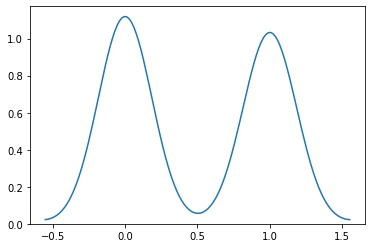

In [58]:
barplot(x=None, y=None, hue=None, data=None, order=None, hue_order=None, estimator=<function mean at 0x10a2a03b0>, ci=95, errcolor='.26')

#3) In your own words, summarize the difference between Bayesian and Frequentist statistics

Frequentist statistics do not have any prior data to model distribution, it relies on sapmling the data from the population given. After sampling and applying techniques such as Confidence Interval and Hypothesis testing, it will come up to a probability statements. Bayesian statistics have the distribution reflecting some prior data or knowledge (that taken from any source), before collecting any data. After collecting some data, it would update the prior distribution to get a new probability, called posterior probability.

## Resources

- [Worked example of Bayes rule calculation](https://en.wikipedia.org/wiki/Bayes'_theorem#Examples) (helpful as it fully breaks out the denominator)
- [Source code for mvsdist in scipy](https://github.com/scipy/scipy/blob/90534919e139d2a81c24bf08341734ff41a3db12/scipy/stats/morestats.py#L139)

## Stretch Goals:

- Go back and study the content from Modules 1 & 2 to make sure that you're really comfortable with them.
- Apply a Bayesian technique to a problem you previously worked (in an assignment or project work) on from a frequentist (standard) perspective
- Check out [PyMC3](https://docs.pymc.io/) (note this goes beyond hypothesis tests into modeling) - read the guides and work through some examples
- Take PyMC3 further - see if you can build something with it!